In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the EMNIST dataset into memory
emnist_train = pd.read_csv('/kaggle/input/emnist/emnist-balanced-train.csv', header=None)
emnist_test = pd.read_csv('/kaggle/input/emnist/emnist-balanced-test.csv', header=None)

# Split the dataset into X (features) and y (labels)
X_train, y_train = emnist_train.iloc[:, 1:], emnist_train.iloc[:, 0]
X_test, y_test = emnist_test.iloc[:, 1:], emnist_test.iloc[:, 0]

In [67]:
# Reshape the features into images
X_train = X_train.values.reshape(-1, 28, 28)
X_test = X_test.values.reshape(-1, 28, 28)

# Normalize the pixel values between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


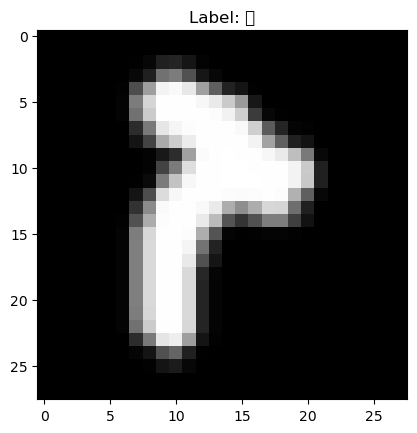

In [68]:
# Plot a sample image from the dataset
plt.imshow(X_train[0], cmap='gray')
plt.title('Label: ' + str(chr(y_train[0] + 96)))
plt.show()

In [69]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes of the training and validation sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (90240, 28, 28), y_train shape: (90240,)
X_val shape: (22560, 28, 28), y_val shape: (22560,)


In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 47)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN model
model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the batch size and number of epochs
batch_size = 128
num_epochs = 10

In [71]:
# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train.values).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val.values).float()

# Create the PyTorch dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [82]:
# Define empty lists to store the training and validation losses and accuracies
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Move the model and loss function to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Train the model
for epoch in range(num_epochs):
    # Set the model to train mode
    model.train()
    
    # Initialize the training loss and accuracy for this epoch
    train_loss = 0.0
    train_acc = 0.0
    
    # Loop over the training batches
    for i, (inputs, labels) in enumerate(train_loader):
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the training loss and accuracy for this batch
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)
    
    # Calculate the average training loss and accuracy for this epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize the validation loss and accuracy for this epoch
    val_loss = 0.0
    val_acc = 0.0
    
    # Disable gradient computation to speed up validation
    with torch.no_grad():
        # Loop over the validation batches
        for inputs, labels in val_loader:
            # Move the inputs and labels to the GPU if available
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            
            # Update the validation loss and accuracy for this batch
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)
    
    # Calculate the average validation loss and accuracy for this epoch
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)
    
    # Print the training and validation losses and accuracies for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save the training and validation losses and accuracies
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)


Epoch 1/10, Train Loss: 0.4777, Train Acc: 0.8363, Val Loss: 0.4789, Val Acc: 0.8358
Epoch 2/10, Train Loss: 0.4566, Train Acc: 0.8414, Val Loss: 0.4905, Val Acc: 0.8377
Epoch 3/10, Train Loss: 0.4450, Train Acc: 0.8443, Val Loss: 0.4642, Val Acc: 0.8441
Epoch 4/10, Train Loss: 0.4345, Train Acc: 0.8480, Val Loss: 0.4930, Val Acc: 0.8395
Epoch 5/10, Train Loss: 0.4246, Train Acc: 0.8505, Val Loss: 0.4795, Val Acc: 0.8393
Epoch 6/10, Train Loss: 0.4200, Train Acc: 0.8513, Val Loss: 0.4727, Val Acc: 0.8416
Epoch 7/10, Train Loss: 0.4170, Train Acc: 0.8530, Val Loss: 0.5018, Val Acc: 0.8331
Epoch 8/10, Train Loss: 0.4084, Train Acc: 0.8549, Val Loss: 0.5147, Val Acc: 0.8250
Epoch 9/10, Train Loss: 0.4098, Train Acc: 0.8544, Val Loss: 0.4966, Val Acc: 0.8289
Epoch 10/10, Train Loss: 0.4023, Train Acc: 0.8565, Val Loss: 0.4639, Val Acc: 0.8404


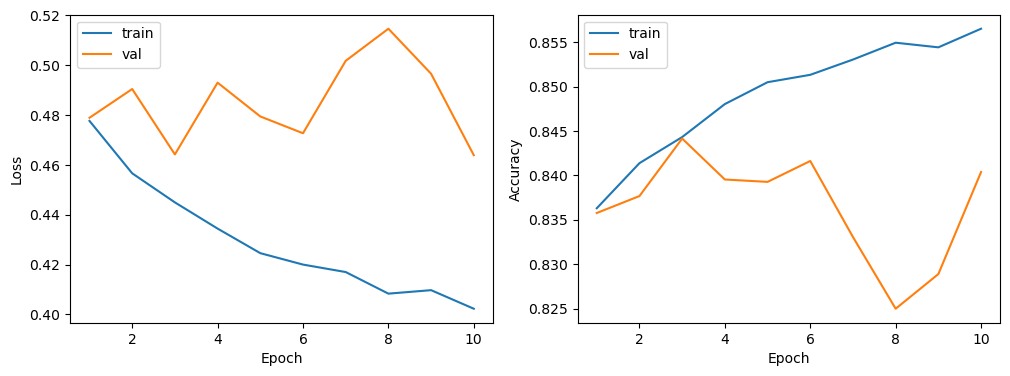

In [84]:
# Plot the training and validation loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='train')
plt.plot(range(1, num_epochs+1), val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='train')
plt.plot(range(1, num_epochs+1), val_accs, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [91]:
torch.save(model.state_dict(), 'model.pt')

In [93]:
model_2 = CNN()
model_2.load_state_dict(torch.load('/kaggle/working/model.pt'))
print(model_2.eval())

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=47, bias=True)
)
